# Flappy bird object detector




### 1. Plot Ground Truth Bounding Boxes


In [23]:
!pip install ultralytics
!rm -rf flappy_bird_dataset
!unzip flappy_bird_dataset.zip > /dev/null 2>&1

In [24]:
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os
import shutil
from PIL import Image
import torch

In [25]:


# Define dataset base path
dataset_path = "/content/flappy_bird_dataset"

# Define correct structure
folders = {
    "images": os.path.join(dataset_path, "images"),
    "labels": os.path.join(dataset_path, "labels"),
}


In [26]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

id2color = {
    '0': (0,255,0),
    '1': (255,0,0)
}

def plot_box(image, bboxes, labels):
    h, w, _ = image.shape

    for box_num, box in enumerate(bboxes):

        x1, y1, x2, y2 = yolo2bbox(box)

        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=id2color[labels[box_num]],
            thickness=thickness
        )
    return image

In [27]:
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.png'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('on')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

0 0.2326388888888889 0.736328125 0.11805555555555555 0.046875

1 0.03819444444444445 0.25 0.18055555555555555 0.5

1 0.03819444444444445 0.9208984375 0.18055555555555555 0.158203125

1 0.9131944444444444 0.0625 0.18055555555555555 0.125

1 0.9131944444444444 0.7333984375 0.18055555555555555 0.533203125

0 0.2326388888888889 0.369140625 0.11805555555555555 0.046875

1 0.06944444444444445 0.0625 0.18055555555555555 0.125

1 0.06944444444444445 0.7333984375 0.18055555555555555 0.533203125

1 0.9444444444444444 0.099609375 0.18055555555555555 0.19921875

1 0.9444444444444444 0.7705078125 0.18055555555555555 0.458984375

0 0.2326388888888889 0.6396484375 0.11805555555555555 0.046875

1 0.8819444444444444 0.095703125 0.18055555555555555 0.19140625

1 0.8819444444444444 0.7666015625 0.18055555555555555 0.466796875



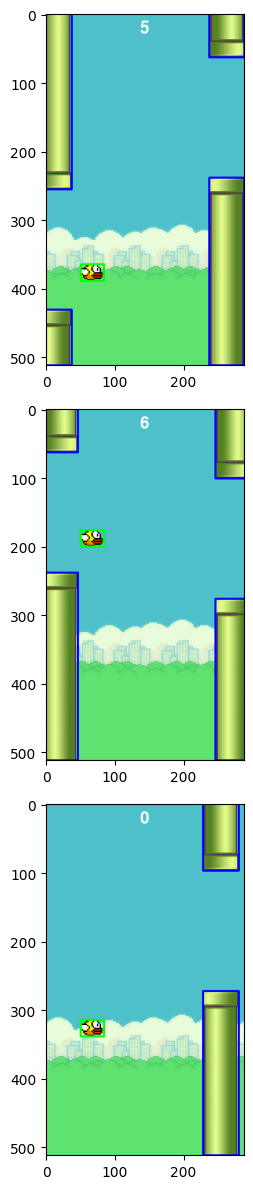

In [28]:
plot(
    image_paths=folders["images"],
    label_paths=folders["labels"],
    num_samples=3,
)

### 2. Training and data prep

In [30]:
# Set seed for reproducibility
random.seed(42)

images_path = folders['images']
labels_path = folders['labels']

# Output paths
train_img_path = os.path.join(dataset_path, 'train/images')
train_lbl_path = os.path.join(dataset_path, 'train/labels')
val_img_path   = os.path.join(dataset_path, 'validation/images')
val_lbl_path   = os.path.join(dataset_path, 'validation/labels')

# Create directories
os.makedirs(train_img_path, exist_ok=True)
os.makedirs(train_lbl_path, exist_ok=True)
os.makedirs(val_img_path, exist_ok=True)
os.makedirs(val_lbl_path, exist_ok=True)

# List all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]
random.shuffle(image_files)

# Split (e.g. 80% train, 20% val)
split_idx = int(0.8 * len(image_files))
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

def move_files(file_list, target_img_dir, target_lbl_dir):
    for img_file in file_list:
        base_name = os.path.splitext(img_file)[0]
        label_file = base_name + ".txt"

        # Full source paths
        src_img = os.path.join(images_path, img_file)
        src_lbl = os.path.join(labels_path, label_file)

        # Full destination paths
        dst_img = os.path.join(target_img_dir, img_file)
        dst_lbl = os.path.join(target_lbl_dir, label_file)

        # Move image
        shutil.copy2(src_img, dst_img)

        # Move label if it exists
        if os.path.exists(src_lbl):
            shutil.copy2(src_lbl, dst_lbl)
        else:
            print(f"⚠️ No label found for: {img_file}")

# Move the files
move_files(train_files, train_img_path, train_lbl_path)
move_files(val_files, val_img_path, val_lbl_path)

print(f"✅ Split complete: {len(train_files)} train / {len(val_files)} val images.")


✅ Split complete: 1207 train / 302 val images.


In [33]:
import yaml

cwd = os.getcwd()

attr = {
    'path': cwd + '/flappy_bird_dataset',
    'train': 'train/images',
    'val': 'validation/images',
    'names': {
        0: 'Bird',
        1: 'Pipe'
    }
}
with open('flappy_bird.yaml', 'w') as f:
    yaml.dump(attr, f)


In [ ]:
EPOCHS = 30
!yolo \
task=detect \
mode=train \
model=yolov12n.pt \
imgsz=512 \
data=flappy_bird.yaml \
epochs={EPOCHS} \
batch=8 \
name=yolov12n \
exist_ok=True

Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=flappy_bird.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profi

In [ ]:
def convert_yolo_to_voc_format(box_record, image_height, image_width):
    x_center_norm = float(box_record[1])
    y_center_norm = float(box_record[2])
    width_norm    = float(box_record[3])
    height_norm   = float(box_record[4])

    box_width  = width_norm * image_width
    box_height = height_norm * image_height

    x_min = image_width * (2*x_center_norm - width_norm) / 2.
    y_min = image_height* (2*y_center_norm - height_norm) / 2.
    x_max = x_min + box_width
    y_max = y_min + box_height

    voc_box_coord =  [int(x_min), int(y_min), int(x_max), int(y_max)]

    return voc_box_coord

def prepare_predictions(model, image_dir_path, image_filenames):

    preds = []
    for image_file in image_filenames:
        img_filepath = os.path.join(image_dir_path, image_file)
        pred_results = model(img_filepath, conf=1e-2)[0].boxes.cpu()

        pred_dict = dict(
                        boxes  = pred_results.xyxy,
                        scores = pred_results.conf,
                        labels = pred_results.cls.type(torch.int)
                       )
        preds.append(pred_dict)
    return preds


def prepare_targets(image_dir_path, label_dir_path, image_filenames, label_filenames):
    targets = []

    for image_file, label_file in zip(image_filenames, label_filenames):

        image_file_path = os.path.join(image_dir_path, image_file)
        label_file_path = os.path.join(label_dir_path, label_file)

        image = cv2.imread(image_file_path)
        height, width = image.shape[:2]

        per_image_box_coords = []
        per_image_box_labels = []

        with open(label_file_path, 'r') as label_txt:
            lines = label_txt.readlines()

        # Iterate through each line.
        for line in lines:
            box_record = line.strip().split()
            box_data = convert_yolo_to_voc_format(box_record, height, width)
            per_image_box_labels.append(int(box_record[0]))
            per_image_box_coords.append(box_data)

        boxes_tensor  = torch.tensor(per_image_box_coords, dtype = torch.float)

        labels_tensor = torch.tensor(per_image_box_labels, dtype = torch.int)

        ground_truth_dict = dict(
                                boxes  = boxes_tensor,
                                labels = labels_tensor
                                )
        targets.append(ground_truth_dict)


    return targets

In [ ]:
from ultralytics import YOLO
import logging

logging.getLogger("ultralytics").setLevel(logging.WARNING)

weight_path = os.path.join(cwd,'runs/detect/yolov8s/weights/best.pt')
model = YOLO(weight_path)

image_dir_path = os.path.join(cwd, 'Dataset/validation/images')
image_filenames = sorted(os.listdir(image_dir_path))
label_dir_path = os.path.join(cwd, 'Dataset/validation/labels')
label_filenames = sorted(os.listdir(label_dir_path))

targets = prepare_targets(image_dir_path, label_dir_path, image_filenames, label_filenames)
preds = prepare_predictions(model, image_dir_path, image_filenames)

print(preds[0])
print(targets[0])


{'boxes': tensor([[ 209.3736,  253.1331,  340.4477,  350.8144],
        [ 195.0126,  234.0437,  366.1520,  374.4329],
        [ 996.8799,  248.2350, 1024.0000,  274.1414]]), 'scores': tensor([0.6918, 0.0524, 0.0155]), 'labels': tensor([0, 0, 0], dtype=torch.int32)}
{'boxes': tensor([[213., 251., 338., 349.]]), 'labels': tensor([0], dtype=torch.int32)}
